<h1>Table of Contents</h1>

<h2>1. Setup and data cleaning</h2>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
import seaborn as sns

from yahoofinancials import YahooFinancials
from core.trading import TradingSimulation

# set plotting style
sns.set(style="ticks", 
        palette="PiYG", 
        font_scale=1.1,
        rc = {"lines.linewidth": 2, 
              "xtick.color" : "#4f4e4e",
              "ytick.color" : "#4f4e4e",
              "axes.spines.top" : False,
              "axes.spines.right" : False,
              "axes.edgecolor": "#4f4e4e",
              "axes.labelcolor": "#4f4e4e",
              "axes.titlesize": 16,
              "axes.titlecolor": "#4f4e4e",
             })

%config InlineBackend.figure_format = 'retina'

pd.set_option('display.float_format', lambda x: '%.2f' % x)

# uncomment below to view the available rc parameters
# plt.rcParams.keys()

In [2]:
# parameters you can change to explore other stock tickers and investment horizon
START_DATE = "2016-02-08"
END_DATE = "2021-02-08"
SELECTED_TICKER = "QQQ"
INTERVAL1 = 5
INTERVAL2 = 20
AMOUNT = 50000

In [3]:
result = YahooFinancials(SELECTED_TICKER)

In [4]:
# save results retruend by the API call
result = YahooFinancials(SELECTED_TICKER)
current_price = result.get_current_price()

In [5]:
# return hisorical prices under the selected ticker
historical_raw = result.get_historical_price_data(START_DATE, END_DATE, "daily")

In [6]:
# drop unix timestamp
historical_price = pd.DataFrame(historical_raw[SELECTED_TICKER]["prices"]).drop(columns="date")

# convert formatted_date to datetime in pandas
historical_price["formatted_date"] = pd.to_datetime(historical_price["formatted_date"])

# set date as index of the dataframe
historical_price.set_index("formatted_date", inplace=True)

# add difference between open and close as a new column
historical_price["diff"] = historical_price["open"] - historical_price["close"]

# drop null values, if any
historical_price = historical_price.dropna()

<h2>2. Understanding hitorical prices</h2>

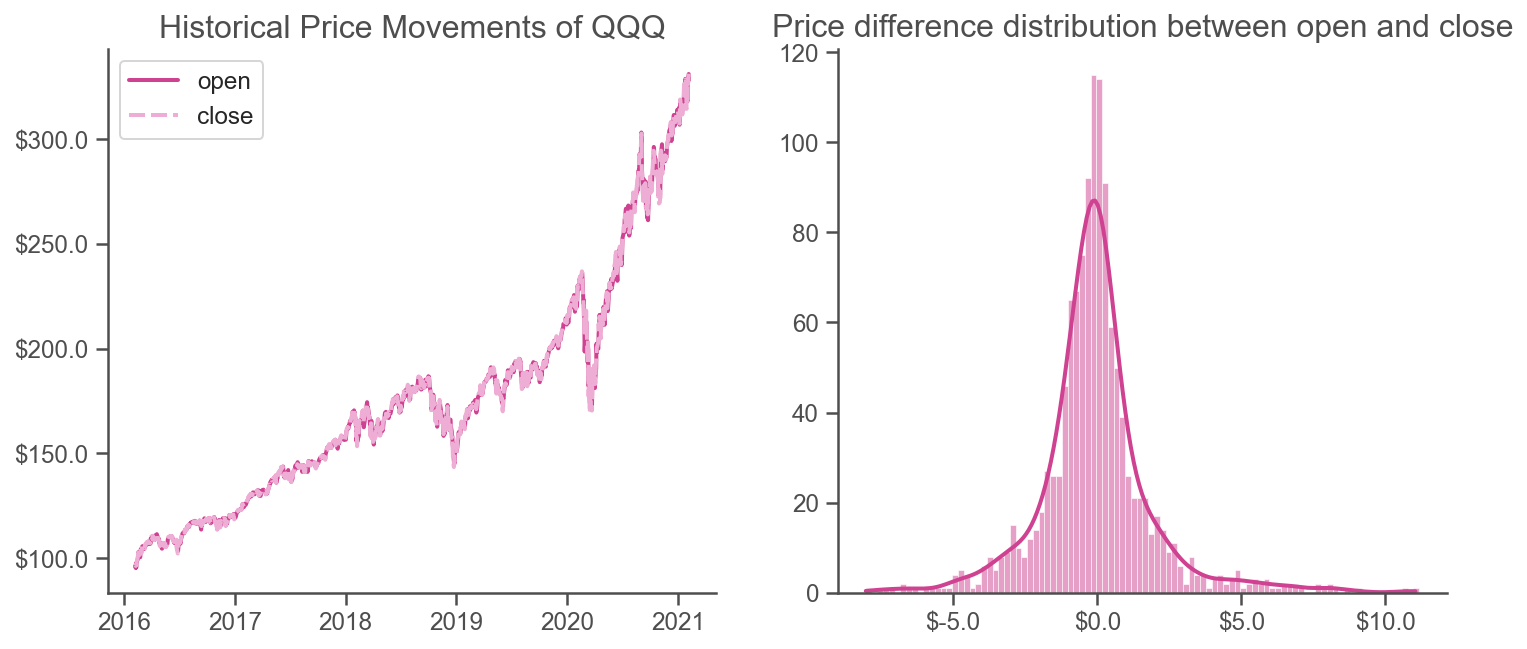

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))

# plot historical open and close prices
sns.lineplot(data=historical_price[["open", "close"]], ax=ax1)
ax1.yaxis.set_major_formatter('${x:1.1f}')
ax1.set_title(f"Historical Price Movements of {SELECTED_TICKER}")
ax1.set(xlabel=None, ylabel=None)

# plot differences between open and close
sns.histplot(data=historical_price["diff"], binwidth=0.2, kde=True, ax=ax2)
ax2.xaxis.set_major_formatter('${x:1.1f}')
ax2.set_title(f"Price difference distribution between open and close")
ax2.set(xlabel=None, ylabel=None)

plt.show()

In [8]:
# hypothesis test on if the difference between historical open and close was > 0
scipy.stats.ttest_1samp(historical_price["diff"], 0, alternative='greater')

Ttest_1sampResult(statistic=-1.0422792079124066, pvalue=0.8512587476824733)

<h2>3. Backtesting trading frequencies</h2>

In [9]:
trading_w = TradingSimulation(historical_price, 5, 50000)
trading_m = TradingSimulation(historical_price, 20, 50000)

In [10]:
result_w = trading_w.compute_portfolio()
result_m = trading_m.compute_portfolio()

In [11]:
combined = pd.concat(
    [result_w[["portfolio_value", "return"]], 
     result_m[["portfolio_value", "return"]]], 
    axis=1
)

names=["value_w", "return_w", "value_m", "return_m"]
combined.columns = names

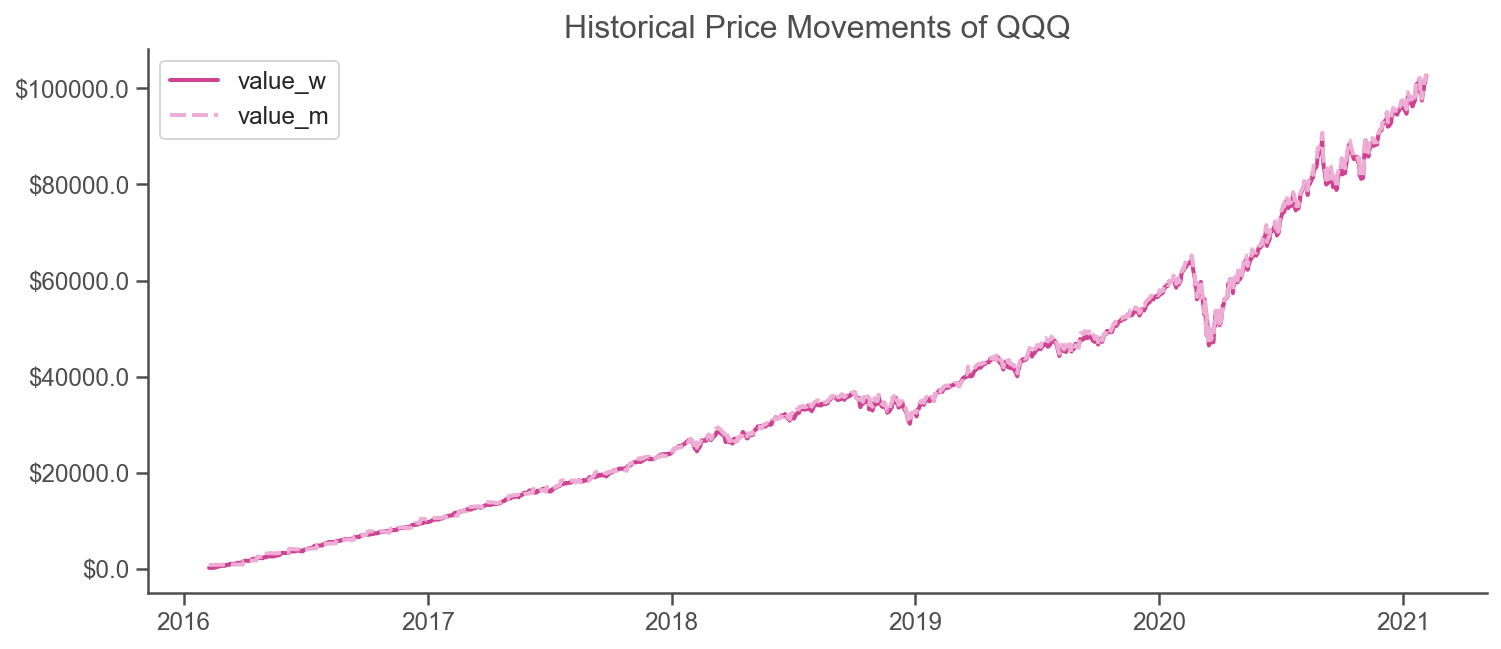

In [12]:
fig, ax = plt.subplots(figsize = (12, 5))

# plot historical open and close prices
sns.lineplot(data=combined[["value_w", "value_m"]])
ax.yaxis.set_major_formatter('${x:1.1f}')
ax.set_title(f"Historical Price Movements of {SELECTED_TICKER}")
ax.set(xlabel=None, ylabel=None)
plt.show()

In [13]:
# run the trading strategy for n times and compute tne terminal values
simulated_terminal_value_w = trading_w.run_simulation(current_price)[0]
simulated_terminal_value_m = trading_m.run_simulation(current_price)[0]

In [128]:
# perform hypothesis test to see if trading monthly generates higher return than weekly over the examined period
scipy.stats.ttest_ind(
    simulated_terminal_value_w, 
    simulated_terminal_value_m, 
    equal_var=False, 
    alternative="two-sided")

Ttest_indResult(statistic=-279.591460792225, pvalue=0.0)

In [15]:
# perfrm Levene test for equal variances
# for simplicity, not running n simulations for this one
scipy.stats.levene(result_w["return"], result_m["return"])

LeveneResult(statistic=0.17232535535804186, pvalue=0.6780888012267545)

<h2>4. Comparing the risk and return for a selection of investments</h2>

In [136]:
TICKERS = ["QQQ", "TSLA", "GME", "BTC-USD", "WMT", "ARKK"]
results = YahooFinancials(TICKERS)

In [137]:
historical_raws = results.get_historical_price_data(START_DATE, END_DATE, "daily")
current_prices = results.get_current_price()

In [138]:
ci_lower = []
ci_upper = []
mean_diff = []
p_var = []

for i in TICKERS:
    # create price dataframe for all tickers and clean up
    historical_price = pd.DataFrame(historical_raws[i]["prices"]).drop(columns="date")
    historical_price["formatted_date"] = pd.to_datetime(historical_price["formatted_date"])
    historical_price.set_index("formatted_date", inplace=True)
    historical_price = historical_price.dropna()
    
    # run simulation
    trading_w = TradingSimulation(historical_price, INTERVAL1, AMOUNT)
    trading_m = TradingSimulation(historical_price, INTERVAL2, AMOUNT)
    
    simulated_w, return_w = trading_w.run_simulation(current_prices[i])
    simulated_m, return_m = trading_m.run_simulation(current_prices[i])
    
    diff_return = np.array(return_m) - np.array(return_w)
    diff_mean = np.mean(diff_return)
    
    ci = scipy.stats.t.interval(
        alpha=0.95, 
        df=len(diff_return)-1, 
        loc=diff_mean, 
        scale=scipy.stats.sem(diff_return)
    ) 
    # add confidence intervals and mean to corresponding lists
    ci_lower.append(ci[0])
    ci_upper.append(ci[1])
    mean_diff.append(diff_mean)
    
    # to check if the risks are significantly different
    result_w = trading_w.compute_portfolio()
    result_m = trading_m.compute_portfolio()
    
    stat, p = scipy.stats.levene(result_w["return"], result_m["return"])
    
    p_var.append(p)

In [139]:
comparisons = pd.DataFrame(
    {"tickers":TICKERS,
    "mean_diff":mean_diff,
    "ci_lower":ci_lower,
    "ci_upper":ci_upper,
    "p_var": p_var
    }
)
comparisons

,tickers,mean_diff,ci_lower,ci_upper,p_var
0,QQQ,0.02,0.02,0.02,0.96
1,TSLA,0.20,0.20,0.20,0.91
2,GME,0.05,0.05,0.05,0.99
3,BTC-USD,0.13,0.12,0.13,0.47
4,WMT,0.01,0.01,0.01,1.00
5,ARKK,0.06,0.06,0.06,0.92


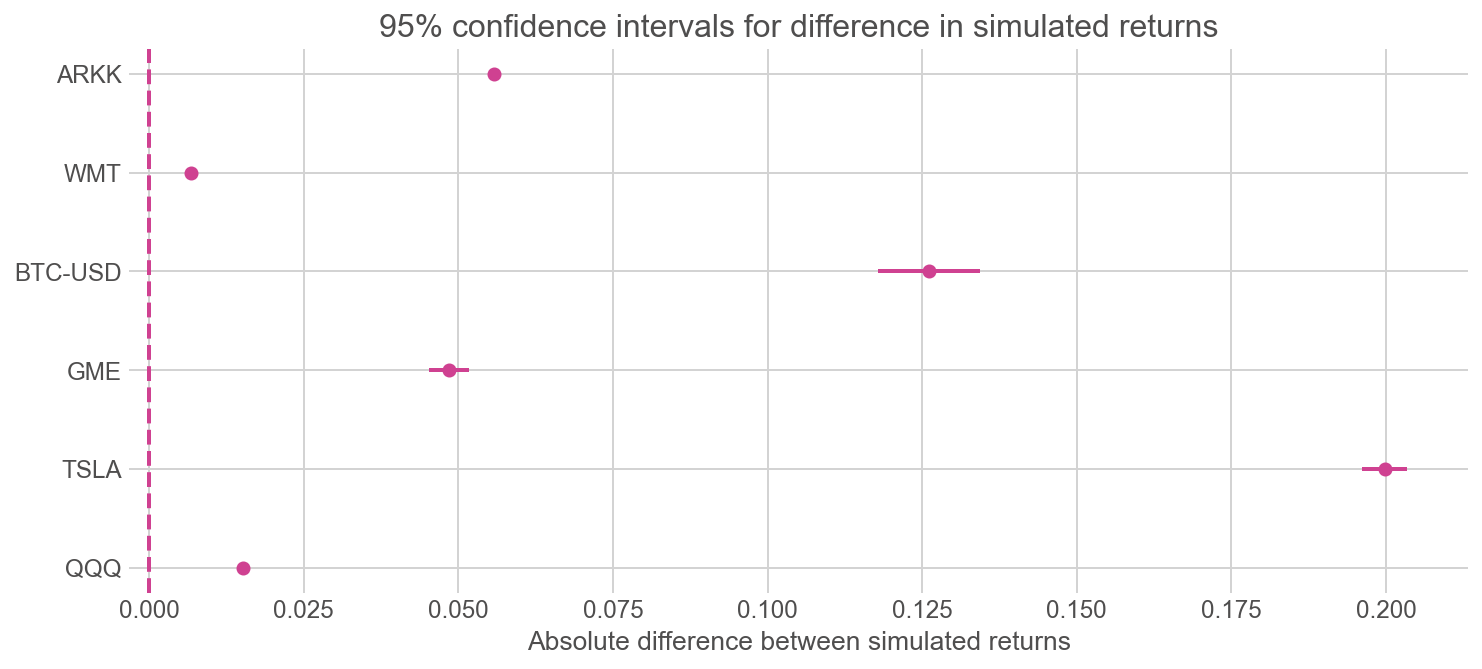

In [140]:
fig, ax = plt.subplots(figsize = (12, 5))

plt.grid(color='#d3d3d3', linestyle='solid')

plt.errorbar(
    x="mean_diff",
    y="tickers", 
    xerr=comparisons["ci_upper"] - comparisons["ci_lower"],
    fmt='o',
    data=comparisons)

ax.set_title(f"95% confidence intervals for difference in simulated returns")
ax.set(xlabel="Absolute difference between simulated returns", ylabel=None)

# hide axis spines
for spine in ax.spines.values():
    spine.set_visible(False)

# hide all ticks
ax.tick_params(length=0)

plt.axvline(x=0, linestyle="--")

plt.show()

In [141]:
result_w = trading_w.compute_portfolio()
result_m = trading_m.compute_portfolio()
scipy.stats.levene(result_w["return"], result_m["return"])

LeveneResult(statistic=0.020426222202884287, pvalue=0.8863645425620315)